#### 1. Setup and Data Loading
This section imports the required libraries and loads the cleaned_r_malaysia_comments.csv dataset. Any comments that are empty after cleaning are dropped to prepare the data for modeling.

In [ ]:
# --- 1.1: Install and Import Necessary Libraries ---
# Using 'quiet' flag to keep the output clean
!pip install scikit-learn tensorflow --quiet

import pandas as pd
import numpy as np
import re

# For Model 1 (Naive Bayes)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# For Model 2 (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("✅ Libraries installed and imported successfully.")

# --- 1.2: Load and Prepare the Dataset ---
# Load the cleaned data from Member A
try:
    # This assumes you have uploaded 'cleaned_r_malaysia_comments.csv' to your Colab environment
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_r_malaysia_comments.csv')
    print(f"📄 Dataset loaded successfully with {len(df)} rows.")
except FileNotFoundError:
    print("❌ Error: 'cleaned_r_malaysia_comments.csv' not found. Please upload the file to your Colab session.")
    df = pd.DataFrame() # Create empty dataframe to avoid further errors

if not df.empty:
    # As we discussed, drop any rows where 'Cleaned_text' is null or just whitespace
    df.dropna(subset=['Cleaned_text'], inplace=True)
    df = df[df['Cleaned_text'].str.strip() != '']
    print(f"🧹 After dropping empty rows, we have {len(df)} comments to work with.")

    # Display the first few rows of our final working dataset
    print("\nHere's a sample of the data we will use for modeling:")
    display(df.head())

✅ Libraries installed and imported successfully.
📄 Dataset loaded successfully with 32054 rows.
🧹 After dropping empty rows, we have 31609 comments to work with.

Here's a sample of the data we will use for modeling:


,Cleaned_text,Comment Score,Comment Timestamp,Post ID,Comment ID
0,minor announcement rmalaysia census collecting...,1,2025-06-17 20:00:37,1ldx8x4,mybo1l1
1,got someone long ago shit gooddddd,1,2025-06-18 02:12:19,1ldx8x4,mydlsxd
2,baffled buyer carousell setting aside dont rea...,1,2025-06-18 04:48:05,1ldx8x4,mye9jjc
3,hello uchubbytrains goth girlfriend speaking n...,2,2025-06-17 20:47:23,1ldx8x4,myby13z
4,feel like covid,1,2025-06-17 22:20:48,1ldx8x4,mycgll9


#### 2. Creating Sentiment Labels
The dataset doesn't have sentiment labels, so we create them using the Comment Score. A simple rule is applied: high scores are marked as positive, negative scores as negative, and the rest as neutral. We then check the distribution of these new labels.

✅ 'sentiment' column created successfully based on 'Comment Score'.

Distribution of sentiments:
sentiment
neutral     21183
positive     8825
negative     1601
Name: count, dtype: int64


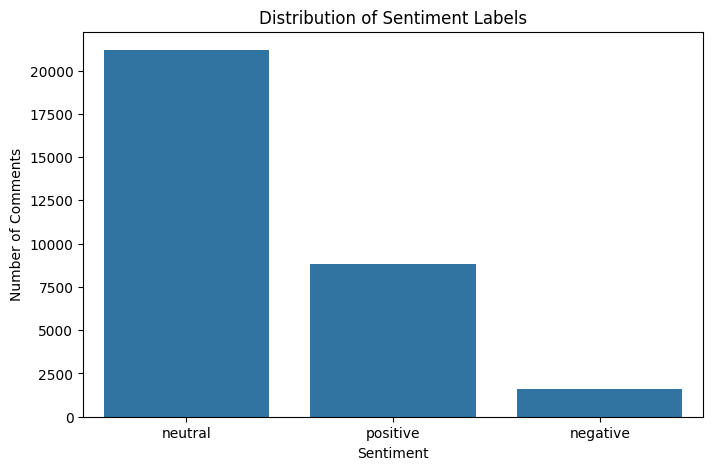

In [ ]:
# --- 2.1: Define Labeling Function ---
def create_sentiment_labels(score):
    """Creates sentiment labels based on comment scores."""
    if score > 5:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# --- 2.2: Apply the Function to Create the 'sentiment' Column ---
if not df.empty:
    df['sentiment'] = df['Comment Score'].apply(create_sentiment_labels)
    print("✅ 'sentiment' column created successfully based on 'Comment Score'.")

    # --- 2.3: Check the Distribution of Our New Labels ---
    print("\nDistribution of sentiments:")
    sentiment_distribution = df['sentiment'].value_counts()
    print(sentiment_distribution)

    # Optional: Visualize the distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
    plt.title('Distribution of Sentiment Labels')
    plt.ylabel('Number of Comments')
    plt.xlabel('Sentiment')
    plt.show()

#### 3. Calculating Class Weights for Imbalance
Our new labels are imbalanced. To fix this, we calculate class weights here. These weights will be used during training to force the model to pay more attention to the less frequent positive and negative classes.

In [ ]:
# --- 3.1: Calculate Class Weights ---
# This helps the model pay more attention to the minority classes (positive and negative)
from sklearn.utils.class_weight import compute_class_weight

if not df.empty:
    # Get the list of classes
    classes = np.unique(df['sentiment'])

    # Get the sentiment labels
    labels = df['sentiment']

    # Calculate weights
    class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

    # Create a dictionary of class weights for Keras/TensorFlow
    class_weights = {i : class_weights_array[i] for i in range(len(classes))}

    print(f"Calculated Class Weights: ")
    for i, cls in enumerate(classes):
        print(f"- {cls}: {class_weights_array[i]:.2f}")

    # We will use the 'class_weights' dictionary later when training our LSTM model.

Calculated Class Weights: 
- negative: 6.58
- neutral: 0.50
- positive: 1.19


#### 4. Data Splitting and Vectorization
Here, we split the data into training (80%) and testing (20%) sets. We then use TfidfVectorizer to convert the text comments into numerical vectors for our first machine learning model.

In [ ]:
# --- 4.1: Split the Data ---
if not df.empty:
    X = df['Cleaned_text']
    y = df['sentiment']

    # Split data into 80% for training and 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Data split into training and testing sets:")
    print(f"- Training data shape: {X_train.shape}")
    print(f"- Testing data shape: {X_test.shape}")

# --- 4.2: Vectorize Text for Naive Bayes ---
# We use TF-IDF to represent the text data for our first model
if not df.empty:
    tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit to top 5000 features

    # Fit and transform the training data
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    # Only transform the test data
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    print("\n✅ Text vectorized for Naive Bayes using TF-IDF.")

Data split into training and testing sets:
- Training data shape: (25287,)
- Testing data shape: (6322,)

✅ Text vectorized for Naive Bayes using TF-IDF.


#### 5. Model 1: Naive Bayes (Baseline)
We train our first model, Multinomial Naive Bayes. This serves as a fast and simple baseline to compare against our more complex model.

✅ Naive Bayes model trained successfully.

--- Naive Bayes Model Evaluation ---
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       320
     neutral       0.67      0.99      0.80      4237
    positive       0.46      0.02      0.03      1765

    accuracy                           0.67      6322
   macro avg       0.38      0.34      0.28      6322
weighted avg       0.58      0.67      0.55      6322



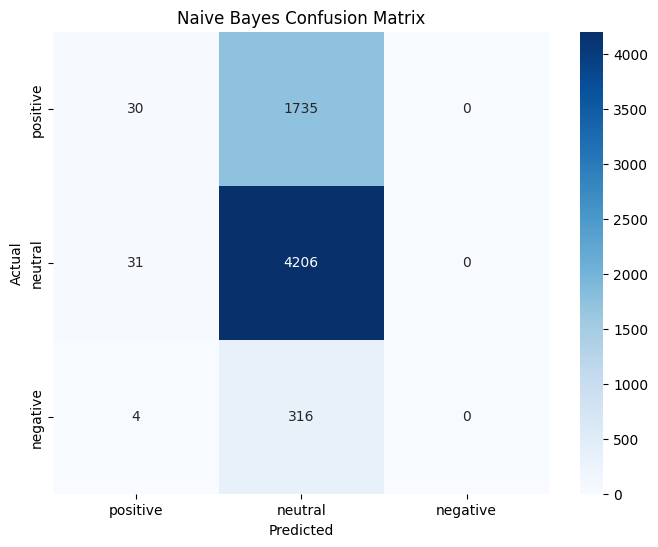

In [ ]:
# --- 5.1: Train the Naive Bayes Model ---
if not df.empty:
    # Initialize the model
    nb_model = MultinomialNB()

    # Train the model
    nb_model.fit(X_train_tfidf, y_train)
    print("✅ Naive Bayes model trained successfully.")

# --- 5.2: Evaluate the Naive Bayes Model ---
if not df.empty:
    # Make predictions on the test set
    y_pred_nb = nb_model.predict(X_test_tfidf)

    # Print the classification report, suppressing the warning
    print("\n--- Naive Bayes Model Evaluation ---")
    print(classification_report(y_test, y_pred_nb, zero_division=0)) # <-- ADD THIS PARAMETER

    # Display the confusion matrix
    cm_nb = confusion_matrix(y_test, y_pred_nb, labels=['positive', 'neutral', 'negative'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
    plt.title('Naive Bayes Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#### 6. Model 2: LSTM (Deep Learning)
Our second model is an LSTM network, which is better at understanding text sequences. We prepare the data using a Tokenizer and apply the class weights during training to handle the data imbalance.

✅ Text tokenized and padded for LSTM.

Label mapping for LSTM: {0: 'negative', 1: 'neutral', 2: 'positive'}

✅ LSTM model built successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 118s 284ms/step - accuracy: 0.3434 - loss: 1.1052 - val_accuracy: 0.4948 - val_loss: 1.0746
Epoch 2/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 88s 220ms/step - accuracy: 0.4590 - loss: 1.0478 - val_accuracy: 0.4302 - val_loss: 1.0516
Epoch 3/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 88s 223ms/step - accuracy: 0.5156 - loss: 0.9117 - val_accuracy: 0.4326 - val_loss: 1.0437
Epoch 4/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 137s 212ms/step - accuracy: 0.5762 - loss: 0.7944 - val_accuracy: 0.4791 - val_loss: 1.0210
Epoch 5/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 140s 206ms/step - accuracy: 0.6202 - loss: 0.7076 - val_accuracy: 0.4548 - val_loss: 1.0742
✅ LSTM model trained successfully.
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step

--- LSTM Model Evaluation ---
              precision    recall  f1-score   support

    negative       0.08      0.27      0.13       320
     neutral       0.71      0.48      0.57      4237
    positive       0.31      0.42      0.35      176

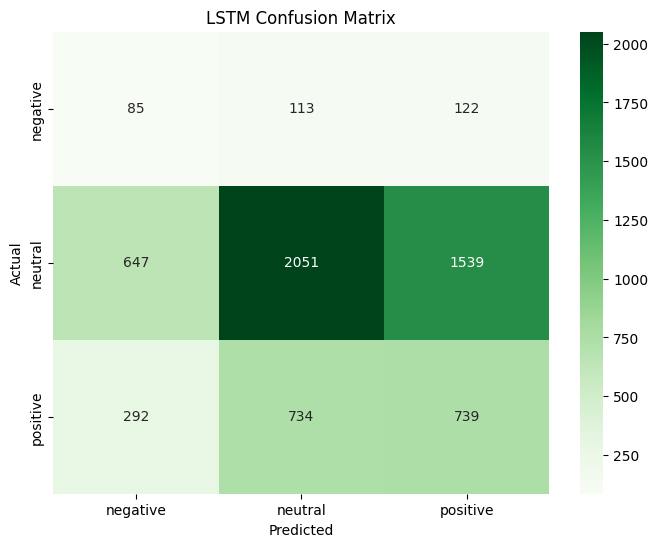

In [ ]:
# --- 6.1: Tokenize and Pad Text for LSTM ---
if not df.empty:
    # Keras Tokenizer setup
    vocab_size = 10000 # Max number of words to keep
    max_length = 150   # Max length of sequences
    trunc_type='post'
    oov_tok = "<OOV>" # Token for out-of-vocabulary words

    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(X_train)

    # Convert texts to sequences of integers
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    # Pad sequences to ensure uniform length
    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, truncating=trunc_type)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

    print("✅ Text tokenized and padded for LSTM.")

    # --- 6.2: Convert Sentiment Labels to Numerical Format ---
    # The LSTM model needs numerical labels instead of text
    y_train_encoded = pd.get_dummies(y_train).values
    y_test_encoded = pd.get_dummies(y_test).values

    # Get the mapping of class names to integers
    label_mapping = {i: col for i, col in enumerate(pd.get_dummies(y_train).columns)}
    print("\nLabel mapping for LSTM:", label_mapping)

# --- 6.3: Build the LSTM Model ---
if not df.empty:
    embedding_dim = 16

    lstm_model = Sequential([
        Embedding(vocab_size, embedding_dim),
        SpatialDropout1D(0.2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(3, activation='softmax') # 3 output neurons for 3 classes
    ])

    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("\n✅ LSTM model built successfully.")
    lstm_model.summary()

# --- 6.4: Train the LSTM Model (with Class Weights) ---
if not df.empty:
    num_epochs = 5
    batch_size = 64

    print("\nTraining LSTM model...")
    history = lstm_model.fit(X_train_padded, y_train_encoded,
                             epochs=num_epochs,
                             batch_size=batch_size,
                             validation_data=(X_test_padded, y_test_encoded),
                             class_weight=class_weights, # <-- HERE is where we use the weights
                             verbose=1)
    print("✅ LSTM model trained successfully.")

# --- 6.5: Evaluate the LSTM Model ---
if not df.empty:
    # Make predictions (these will be probabilities)
    y_pred_lstm_probs = lstm_model.predict(X_test_padded)
    # Convert probabilities to class predictions
    y_pred_lstm = np.argmax(y_pred_lstm_probs, axis=1)

    # We need to convert y_test_encoded back to single-digit labels for evaluation
    y_test_single_label = np.argmax(y_test_encoded, axis=1)

    # Get class names from our mapping
    class_names = list(label_mapping.values())

    # Print the classification report
    print("\n--- LSTM Model Evaluation ---")
    print(classification_report(y_test_single_label, y_pred_lstm, target_names=class_names))

    # Display the confusion matrix
    cm_lstm = confusion_matrix(y_test_single_label, y_pred_lstm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title('LSTM Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#### 7. Final Model Comparison
This section brings the performance metrics from both the Naive Bayes and LSTM models into a single summary table. This allows for a direct, side-by-side comparison to easily select the best-performing model for our project.

In [ ]:
# --- 8.1: Create a Summary of Performance Metrics ---

# Generate classification reports as dictionaries, suppressing the warning for Naive Bayes
report_nb = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0) # <-- ADD zero_division=0 HERE
# For LSTM, we need to use the numerically encoded labels and target names
report_lstm = classification_report(y_test_single_label, y_pred_lstm, target_names=class_names, output_dict=True)

# Extract key metrics into a structured dictionary
comparison_data = {
    'Metric': ['Precision (negative)', 'Recall (negative)', 'F1-Score (negative)',
               'Precision (positive)', 'Recall (positive)', 'F1-Score (positive)',
               'Overall Accuracy'],
    'Naive Bayes': [
        f"{report_nb['negative']['precision']:.2f}",
        f"{report_nb['negative']['recall']:.2f}",
        f"{report_nb['negative']['f1-score']:.2f}",
        f"{report_nb['positive']['precision']:.2f}",
        f"{report_nb['positive']['recall']:.2f}",
        f"{report_nb['positive']['f1-score']:.2f}",
        f"{report_nb['accuracy']:.2f}"
    ],
    'LSTM': [
        f"{report_lstm['negative']['precision']:.2f}",
        f"{report_lstm['negative']['recall']:.2f}",
        f"{report_lstm['negative']['f1-score']:.2f}",
        f"{report_lstm['positive']['precision']:.2f}",
        f"{report_lstm['positive']['recall']:.2f}",
        f"{report_lstm['positive']['f1-score']:.2f}",
        f"{report_lstm['accuracy']:.2f}"
    ]
}

# Create and display a Pandas DataFrame for easy comparison
df_comparison = pd.DataFrame(comparison_data)
df_comparison.set_index('Metric', inplace=True)

print("--- Final Model Performance Comparison ---")
display(df_comparison)

--- Final Model Performance Comparison ---


,Naive Bayes,LSTM
Metric,,
Precision (negative),0.00,0.08
Recall (negative),0.00,0.27
F1-Score (negative),0.00,0.13
Precision (positive),0.46,0.31
Recall (positive),0.02,0.42
F1-Score (positive),0.03,0.35
Overall Accuracy,0.67,0.45


#### 8. Export the Final Model and Tokenizer
Based on the comparison, the LSTM model is the clear winner. Here, we save the trained LSTM model and its corresponding tokenizer. These two files are the final deliverables needed for the next stage of the project pipeline.

In [ ]:
# --- 8.1: Save the LSTM Model and Tokenizer ---

# Save the trained LSTM model
lstm_model.save('sentiment_lstm_model.h5')

# Save the tokenizer so Member C can preprocess new data the exact same way
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\n✅ LSTM model saved to 'sentiment_lstm_model.h5'")
print("✅ Tokenizer saved to 'tokenizer.pickle'")

from google.colab import files
files.download('sentiment_lstm_model.h5')
files.download('tokenizer.pickle')


✅ LSTM model saved to 'sentiment_lstm_model.h5'
✅ Tokenizer saved to 'tokenizer.pickle'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>